# Fidelity vs different things

#### Hamiltonian

$$
\frac{\hat{H}_{bare}}{\hbar} = -\hat{a}^\dagger\hat{a}\tilde{\Delta} + \omega_c\hat{c}^\dagger\hat{c}
$$

$$
\frac{\hat{H}_{int}}{\hbar} = -\tilde{G}\left(\hat{a}^\dagger\hat{c} + \hat{a}\hat{c}^\dagger \right)
$$

$$ 
\hat{H} = \hat{H}_{bare} + \hat{H}_{int}
$$
Here, $\tilde{G}$ is the boosted coupling constant

#### Libraries

In [1]:
import numpy as np
from qutip import *

#### Parameters

One dimensionality satisfied
RHS is greater then LHS by, 11.816 times
drive power =  8.584293215184512e-10
eta_l and eta_p :  450.0547675537846 4.500547675537846
omega_c =  172.268
omega_d =  126.564
omega_c-omega_d =  45.704
g_prime/gamma_0 =  0.053
number of thermal photons in atomic modes c and d:  2.963996425317431e-180 1.264118188079506e-132


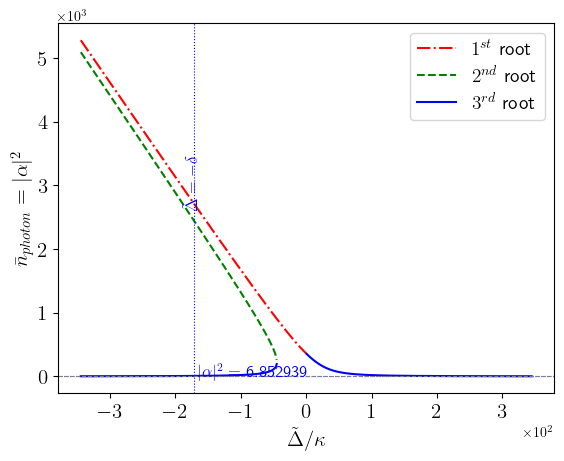

photon number at (delta_tilde = -small_delta) is 6.866789
Q_cs = -0.08776534651866302 and Q_ds = -0.1194450030196379
|alpha_s|^2 (photon number) =  6.853
G_tilde =  4.08
Criterion satisfied
ratio of RHS by LHS:  3.086464385691955
LHS 1898.0997665922864
K.E 5522.4173300773045
Coll 336.0000000000001
scattering rate less than 1
scattering rate 5.768559671149552e-06
Real part of the eigenvalues of the Jacobian matrix are: [-0.24721298 -0.24708444 -0.00562817 -0.2446426  -0.24980958 -0.00563889]
Eigen values with positive real part []
The system is stable.


In [2]:
%run ./bistability_plot.ipynb

In [3]:
# Define constants
omega_c = np.round(omega_c, 3)

G0 = np.round(np.abs(G_tilde_val), 3)

nth_c = 0


#### All function definitions

In [4]:
def thermal_state(n_th, dim):
    """Generate a thermal state with mean phonon number n_th."""
    return thermal_dm(dim, n_th)

# Time-dependent functions
def switch_function(t, t_start, t_off, off_duration, smoothness):
    """
    Defines a smooth function that switches on and off based on given parameters.

    arguments:
    t: Time at which the function is evaluated.
    t_on: The time at which the function switches on.
    t_off: The time at which the function switches off.
    offduration: The duration for which the function stays off.
    smoothness: Controls how smoothly the function switches off and on.

    Returns:
    The value of the function at time t.
    """
    def switching_on(t_on):
        return 0.5 * (1 + np.tanh(smoothness * (t - t_on)))
    
    def switching_off(t_off):
        return 0.5 * (1 - np.tanh(smoothness * (t - t_off)))

    return switching_on(t_start)*switching_off(t_off) + switching_on(t_off + off_duration)

def Gt(t, args):
    """ args is a dictionary containing a list of parameters
    """
    t_start = args['t_start']
    t_off   = args['t_off']
    off_duration = args['off_duration']
    smoothness   = args['smoothness']
    global G0, switch_function
    return G0*switch_function(t, t_start, t_off, off_duration, smoothness)


#### Define the Hilbert space and Hamiltonian

In [5]:
# Define annihilation operators for each mode
N1 = 4  # Truncation level for Fock space
N2 = 4

# Modes a1, a2, c, d
a  = destroy(N1)
c  = destroy(N2)

# Create the Hilbert space by tensoring the operators
a_op = tensor(a, qeye(N1))
c_op  = tensor(qeye(N1), c)

# Number operators in composite space
n_a_op = a_op.dag() * a_op
n_c_op = c_op.dag() * c_op

# Define the Hamiltonian components
# time independent parts
# H_00 = -n_a_op * Delta + n_c_op * omega_c

# time dependent parts
# beam splitter part
H_10 = -(a_op.dag() * c_op + a_op * c_op.dag())


# Full Hamiltonian 
# H = [H_00,                                     # here, [H_10, Gt] means H_10*Gt and [H_00, [H_10, Gt]] means H_00 + H_10*Gt.
#     [H_10, Gt]
# ]

# Full Hamiltonian 
H = [[H_10, Gt]]


# Collapse operators
c_ops_list = [
    np.sqrt(kappa) * a_op,                  # Optical loss mode a
    np.sqrt(gamma_m * (nth_c + 1)) * c_op,  # Mechanical damping (decay)
    np.sqrt(gamma_m * nth_c) * c_op.dag()
]

In [6]:
# rotate the state
theta = -np.pi/2

# Unitary transformation to get rid of any global phase after reading
def unitary_rotation_operator (theta,dim):
    
    # Define creation and annihilation operators for each mode
    a = destroy(dim)  # Mode a

    # Define number operators
    num_a = a.dag() * a

    # Define the rotation operators
    U_a = (-1j * theta * num_a).expm()  # Rotation for mode a

    return U_a


#### Define all time related parameters

In [7]:
# Time range and parameters
period = np.pi / (2 * G0)

t_start      = -100
t_write      = period

smoothness   = 50

off_duration = np.linspace(10*period, 20000*period, 15)
t_read       = np.array([x + 2*period for x in off_duration])

#### Generate data for plotting

In [8]:
# Dictionary for storing options
options_dic = {"progress_bar": False, "store_states": True, "atol":1e-5, "rtol": 1e-4, "nsteps":800}

In [9]:
# minimum allowed fidelity
min_fid_val = 50

# list of states
initial_state_list = []
mech_state     = thermal_dm(N2, nth_c)
opt_state_list = [fock_dm(N1, 1), fock_dm(N1, 2), ket2dm((fock(N1, 0) + fock(N1, 1)).unit()), ket2dm((fock(N1, 1) + fock(N1, 2)).unit())]

# list of filenames
filename_list = ["fid_vs_stime_1ph.txt", "fid_vs_stime_2ph.txt", "fid_vs_stime_sup01.txt", "fid_vs_stime_sup12.txt"]
dm_name_list = ["dm_1ph.txt", "dm_2ph.txt", "dm_sup01.txt", "dm_sup12.txt"]
for opt_state in opt_state_list:
    initial_state_list.append(tensor(opt_state, mech_state))

# list to store the density matrices
retrieved_dm_list = [[],[],[],[]]

for i, initial_state in enumerate(initial_state_list):
    # list to store the fidelity values
    fidelity_vals= []

    print("iteration number:", i)

    if i == 1:
        off_duration = np.linspace(10*period, 20000*period, 20)
    else:
        off_duration = np.linspace(10*period, 20000*period, 20)
    
    t_read       = np.array([x + 2*period for x in off_duration])
    
    for j, storage_time in enumerate(off_duration):
        t_total = t_read[j] + 5*period
        t_eval = (0, t_total)
        dt = 0.1
        nt = int(t_total/dt)
        time_points = np.linspace(t_eval[0],t_eval[1] , nt)

        # Dictionary for storing arguments
        args_dic = {'t_start': t_start, 't_off': t_write, 'off_duration': storage_time, 'smoothness': smoothness, 'delta': delta}

        # solve using qutip.mesolve()
        result = mesolve(H, initial_state, time_points, c_ops = c_ops_list, e_ops= None, args = args_dic, options = options_dic)
        
        # retrieval time index
        retrieval_index = np.abs(np.array(time_points) - t_read[j]).argmin()      # index of the time of retrieval

        # density matrix of the retrieved optical mode
        rho_opt_read = result.states[retrieval_index].ptrace([0])

        U_inverse_r = unitary_rotation_operator(2*theta, N1).inv()   # take the inverse of the rotation matrix since we want to revert the phase change

        rho_opt_read_rotated = U_inverse_r*rho_opt_read*U_inverse_r.dag()       # or np.dot(U_total, psi_norm)

        temp_fid_val = fidelity(opt_state_list[i], rho_opt_read_rotated)  # Fidelity between optical state at t = 0 and t = t_read

        if np.round(temp_fid_val, 3)*100 < min_fid_val:
            print(f"Terminating loop as fidelity is less than 50%")
            break
        
        fidelity_vals.append(np.round(temp_fid_val, 3)*100)

        retrieved_dm_list[i].append(rho_opt_read)

    # Stack x and y into two columns
    fed_data = np.column_stack((t_read[0:len(fidelity_vals)], fidelity_vals))

    # Save to text file
    np.savetxt(filename_list[i], fed_data, comments='')
    print("Data saved")

iteration number: 0
Data saved
iteration number: 1
Data saved
iteration number: 2
Data saved
iteration number: 3
Data saved


Data saved
iteration number: 1
Data saved
iteration number: 2
Data saved
iteration number: 3
Data saved


# Plot

In [10]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# enable TeX fonts
plt.rcParams['text.usetex'] = True

# Set the global font size for all legends
mpl.rcParams['legend.fontsize'] = 14

# Set the global font size for all axis labels
mpl.rcParams['axes.labelsize'] = 14

# Set the global font style for all axis  labels
plt.rcParams['font.family'] = 'Times New Roman'

#### Plot the Wigner functions

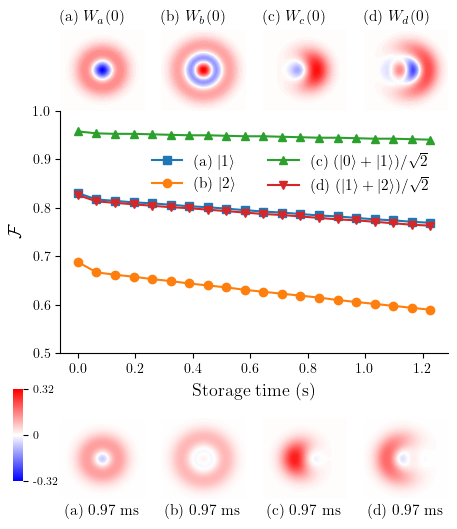

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec
from matplotlib import cm, colors
import matplotlib.pyplot as plt
import matplotlib as mpl


from matplotlib import rcParams

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']  # Or 'DejaVu Serif', 'Georgia'
rcParams['mathtext.fontset'] = 'stix'

# Replace these with your actual file paths
file1 = 'fid_vs_stime_1ph.txt'
file2 = 'fid_vs_stime_2ph.txt'
file3 = 'fid_vs_stime_sup01.txt'
file4 = 'fid_vs_stime_sup12.txt'

# 3D surface data for the inset
xvec = np.linspace(-2.9, 2.9, 256)
X = xvec
Y = xvec
X, Y = np.meshgrid(X, Y)

# Load data assuming two columns: x and y
x1, y1 = np.loadtxt(file1, unpack=True)
x2, y2 = np.loadtxt(file2, unpack=True)
x3, y3 = np.loadtxt(file3, unpack=True)
x4, y4 = np.loadtxt(file4, unpack=True)

x = [x1, x2, x3, x4]

# Intial Wigner functions
W01 = wigner(opt_state_list[0], xvec, xvec)
W02 = wigner(opt_state_list[1], xvec, xvec)
W03 = wigner(opt_state_list[2], xvec, xvec)
W04 = wigner(opt_state_list[3], xvec, xvec)

tn = 15     # time index
# list of Wigner functions
Zs = [wigner(opt_state_list[0], xvec, xvec),
      wigner(opt_state_list[1], xvec, xvec),
      wigner(opt_state_list[2], xvec, xvec),
      wigner(opt_state_list[3], xvec, xvec),
      wigner(retrieved_dm_list[0][tn], xvec, xvec),
      wigner(retrieved_dm_list[1][tn], xvec, xvec),
      wigner(retrieved_dm_list[2][tn], xvec, xvec),
      wigner(retrieved_dm_list[3][tn], xvec, xvec)]

# Shared color limits
vmin = min(W01.min(), W02.min(), W03.min(), W04.min())
vmax = max(W01.max(), W02.max(), W03.max(), W04.max())

# titles for the plots
titles_top = [rf"(a) $W_a(0)$", rf"(b) $W_b(0)$", rf"(c) $W_c(0)$", rf"(d) $W_d(0)$"]

# Create the figure with 3 rows: top contours, main plot, bottom contours
fig = plt.figure(figsize=(5, 6.1))
gs = gridspec.GridSpec(5, 4, height_ratios=[1, -0.4, 3, 0.4, 1])

# Top contour plots
for i in range(4):
    ax = plt.subplot(gs[0, i])
    ax.contourf(X, Y, Zs[i], cmap='bwr', vmin=vmin, vmax=vmax, levels=64)
    ax.axis('off')
    ax.set_title(titles_top[i], fontsize=11, loc='left')

# Main plot
ax_main = plt.subplot(gs[2, :])
# customize plot border
ax_main.spines['top'].set_visible(False)
ax_main.spines['right'].set_visible(False)
ax_main.spines['left'].set_visible(True)
ax_main.spines['bottom'].set_visible(True)

# background color
ax_main.set_facecolor('none')

ax_main.plot(x1/kappa_0, y1/100, label=r'(a) $|1\rangle$', marker='s')
ax_main.plot(x2/kappa_0, y2/100, label=r'(b) $|2\rangle$', marker='o')
ax_main.plot(x3/kappa_0, y3/100, label=r'(c) $(|0\rangle + |1\rangle)/\sqrt{2}$', marker='^')
ax_main.plot(x4/kappa_0, y4/100, label=r'(d) $(|1\rangle + |2\rangle)/\sqrt{2}$', marker='v')

ax_main.set_ylim(0.5, 1)
ax_main.set_xlabel(r'Storage time (s)', fontsize = 13, labelpad=5)
ax_main.set_ylabel(r'$\mathcal{F}$', fontsize = 13, labelpad=5)
ax_main.legend(fontsize = 11, bbox_to_anchor=(0.2, 0.6), facecolor='none', frameon=False, ncol=2)
ax_main.ticklabel_format(style='sci', axis='y', scilimits=(1,2))
ax_main.ticklabel_format(style='sci', axis='x', scilimits=(1,2))

# Bottom contour plots
for i in range(4):
    ax = plt.subplot(gs[4, i])
    ax.contourf(X, Y, Zs[i+4], cmap='bwr', vmin=vmin, vmax=vmax, levels=64)
    ax.axis('off')
    number = x[i][tn]
    letter = chr(ord('a') + i)
    ax.set_title(rf"({letter}) ${np.round(number/kappa_0, 2)}$ ms", fontsize=11, y=-0.3)

# Plot a vertical line at t = T_period
y_min, y_max = ax_main.get_ylim()      # Get the limits of the y-axis
y_center = (y_min + y_max)/ 2      # Calculate the center of the y-axis


# Customize the colorbar
#####################################################
# Color normalization and colorbar
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# colorbar position on the entire plot
cbar_ax = fig.add_axes([0.03, 0.14, 0.02, 0.15]) # [left, bottom, width, height]

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.bwr), cax=cbar_ax, orientation = "vertical")

# Custom tick locations and labels
tick_locs = [vmin,0, vmax]
tick_labels = [np.round(vmin,2),0, np.round(vmax,2)]

# Apply custom ticks and labels
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(tick_labels)

# Remove border
for spine in cbar.ax.spines.values():
    spine.set_visible(False)

# Change font size of tick labels
cbar.ax.tick_params(labelsize=8)

# Make figure background transparent
fig.patch.set_alpha(0.0)

# margin
plt.margins(0)

#save the plot to a file
filename = 'figure_a2.svg'
plt.savefig(filename, format='svg', dpi=32, transparent=True)

plt.show()
